In [1]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import keras.backend as K
from tensorflow.keras.layers import Input, Flatten, Dense, Lambda, Reshape, Conv2D, Conv2DTranspose, Embedding, Dropout, Layer, BatchNormalization, Activation, LayerNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

2025-04-07 09:05:25.669163: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-07 09:05:26.041526: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744016726.217924   17182 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744016726.256172   17182 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-07 09:05:26.594088: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
train_df = pd.read_parquet("sst2_sentiment_dataset/sst2_sentiment_dataset/sst2_train.parquet")
train_df.head()

ImportError: Unable to find a usable engine; tried using: 'pyarrow', 'fastparquet'.
A suitable version of pyarrow or fastparquet is required for parquet support.
Trying to import the above resulted in these errors:
 - Missing optional dependency 'pyarrow'. pyarrow is required for parquet support. Use pip or conda to install pyarrow.
 - Missing optional dependency 'fastparquet'. fastparquet is required for parquet support. Use pip or conda to install fastparquet.

In [ ]:
valid_df = pd.read_parquet("sst2_sentiment_dataset/sst2_sentiment_dataset/sst2_valid.parquet")
valid_df.head()

,idx,sentence,label
0,0,it 's a charming and often affecting journey .,1
1,1,unflinchingly bleak and desperate,0
2,2,allows us to hope that nolan is poised to emba...,1
3,3,"the acting , costumes , music , cinematography...",1
4,4,"it 's slow -- very , very slow .",0


In [21]:
train_df = train_df.sample(frac=1, random_state=42).reset_index(drop=True)
train_df = train_df.iloc[5000:]
test_df = train_df.iloc[:5000]
test_df.head()

,idx,sentence,label
5000,38474,witty and often surprising,1
5001,30765,the teen-exploitation playbook,0
5002,64295,kicks into gear,1
5003,19263,without much success,0
5004,26473,was painful,0


In [22]:
vocab_size = 10000
embedding_dim = 128
max_len = 100
hidden_units = 128

In [23]:
# Install necessary packages
!pip install nltk tensorflow

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import re

# Download NLTK resources
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

# Text cleaning function
def clean_text(text):
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d', '', text)
    text = text.lower()
    tokens = word_tokenize(text)


    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]

    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    return ' '.join(tokens)

# 1. Text Cleaning
train_df['sentence_clean'] = train_df['sentence'].apply(clean_text)
valid_df['sentence_clean'] = valid_df['sentence'].apply(clean_text)
test_df['sentence_clean'] = test_df['sentence'].apply(clean_text)

# 2. Replace empty strings with placeholder
train_df['sentence_clean'].replace('', '<OOV>', inplace=True)
valid_df['sentence_clean'].replace('', '<OOV>', inplace=True)
test_df['sentence_clean'].replace('', '<OOV>', inplace=True)

# 3. Tokenizer Fit
tokenizer = Tokenizer(num_words = vocab_size, oov_token='<OOV>')
full_corpus = pd.concat([train_df['sentence_clean'], valid_df['sentence_clean'], test_df['sentence_clean']])
tokenizer.fit_on_texts(full_corpus)

# 4. Sequences & Padding
X_train = pad_sequences(tokenizer.texts_to_sequences(train_df['sentence_clean']), maxlen=max_len, padding='post')
X_valid = pad_sequences(tokenizer.texts_to_sequences(valid_df['sentence_clean']), maxlen=max_len, padding='post')
X_test = pad_sequences(tokenizer.texts_to_sequences(test_df['sentence_clean']), maxlen=max_len, padding='post')

print("Preprocessing Complete")

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
<ipython-input-23-b3d73f316f4a>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['sentence_clean'] = test_df['sentence'].apply(clean_text)
<ipython-input-23-b3d73f316f4a>:40: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the i

Preprocessing Complete


In [24]:
print(X_train[8])
y_train = np.array(train_df['label'].astype(int))
y_valid = np.array(valid_df['label'].astype(int))
y_test = np.array(test_df['label'].astype(int))
print(y_train)

[  99 1221    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0]
[1 0 1 ... 0 1 1]


In [25]:
class RNN(Layer):
    def __init__(self, hidden_units):
        super(RNN, self).__init__()
        self.hidden_units = hidden_units
        self.W_h = Dense(hidden_units, activation='tanh',
                        kernel_initializer='glorot_uniform')
        self.W_x = Dense(hidden_units, activation='tanh',
                        kernel_initializer='glorot_uniform')
        self.W_o = Dense(1)

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        h_t = tf.zeros((batch_size, self.hidden_units))

        for x_t in tf.unstack(inputs, axis=1):

            h_t = self.W_h(h_t) + self.W_x(x_t)
            h_t = tf.nn.dropout(h_t, rate=0.2)

        output = self.W_o(h_t)
        return output

def build_rnn():
    inputs = Input(shape=(max_len,))

    embedding = Embedding(input_dim=vocab_size, output_dim=embedding_dim,
                         embeddings_regularizer=tf.keras.regularizers.l2(0.001))(inputs)

    normalized = BatchNormalization()(embedding)

    rnn_output = RNN(hidden_units)(normalized)


    output = Activation('sigmoid')(rnn_output)

    model = Model(inputs=inputs, outputs=output, name='RNN')

    optimizer = Adam(learning_rate=1e-4)

    model.compile(optimizer=optimizer,
                 loss='binary_crossentropy',
                 metrics=['accuracy'])
    return model

In [26]:
# Compile and summarize
rnn_model = build_rnn()
rnn_model.summary()

Model: "RNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_2 (Embedding)              │ (None, 100, 128)            │       1,280,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 100, 128)            │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rnn_2 (RNN)                          │ (None, 1)                   │          33,153 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 1)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,313,665 (5.01 MB)

 Trainable params: 1,313,409 (5.01 MB)

 Non-trainable params: 256 (1.00 KB)

In [27]:
history = rnn_model.fit(X_train, y_train, epochs = 20, batch_size = 64, validation_data = (X_valid, y_valid))


Epoch 1/20
975/975 ━━━━━━━━━━━━━━━━━━━━ 194s 144ms/step - accuracy: 0.5227 - loss: 1.3483 - val_accuracy: 0.5115 - val_loss: 0.9700
Epoch 2/20
975/975 ━━━━━━━━━━━━━━━━━━━━ 38s 9ms/step - accuracy: 0.5301 - loss: 0.9223 - val_accuracy: 0.5011 - val_loss: 0.8424
Epoch 3/20
975/975 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.5375 - loss: 0.8136 - val_accuracy: 0.5424 - val_loss: 0.7705
Epoch 4/20
975/975 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.5355 - loss: 0.7577 - val_accuracy: 0.4908 - val_loss: 0.7446
Epoch 5/20
975/975 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.5450 - loss: 0.7246 - val_accuracy: 0.5023 - val_loss: 0.7203
Epoch 6/20
975/975 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.5376 - loss: 0.7080 - val_accuracy: 0.5000 - val_loss: 0.7139
Epoch 7/20
975/975 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - accuracy: 0.5516 - loss: 0.6986 - val_accuracy: 0.5161 - val_loss: 0.7042
Epoch 8/20
975/975 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.5461 - loss: 0.6953 -

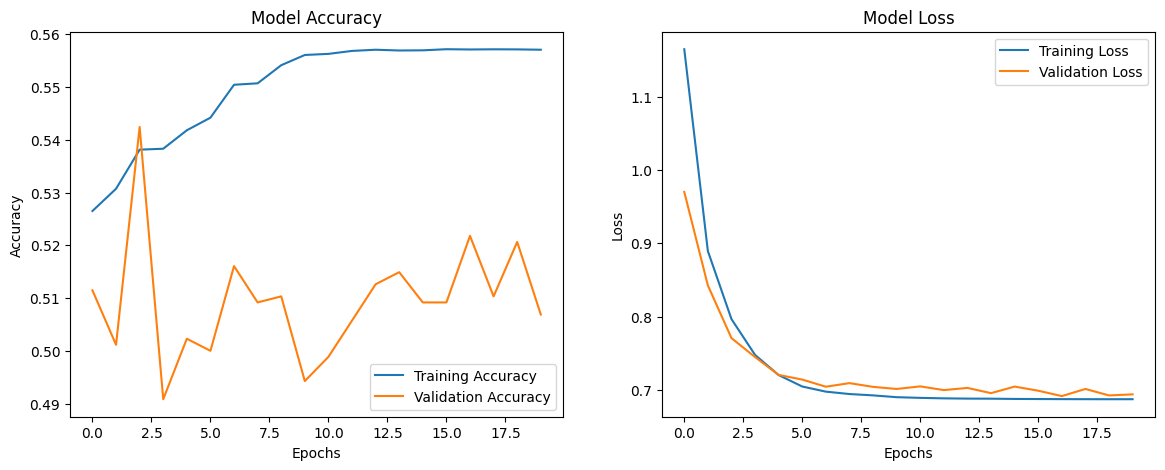

In [28]:
def plot_training_history(history):
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Plot accuracy
    axes[0].plot(history.history['accuracy'], label='Training Accuracy')
    axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
    axes[0].set_title('Model Accuracy')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Accuracy')
    axes[0].legend()

    # Plot loss
    axes[1].plot(history.history['loss'], label='Training Loss')
    axes[1].plot(history.history['val_loss'], label='Validation Loss')
    axes[1].set_title('Model Loss')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Loss')
    axes[1].legend()

    plt.show()

plot_training_history(history)


In [29]:
# Make predictions
y_pred_probs = rnn_model.predict(X_test)  # Get predicted probabilities
y_pred = (y_pred_probs > 0.5).astype(int)   # Convert to binary predictions

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# Print results
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print("\nConfusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

157/157 ━━━━━━━━━━━━━━━━━━━━ 65s 212ms/step
Accuracy: 0.5528
Precision: 0.5603
Recall: 0.9527
F1 Score: 0.7056

Confusion Matrix:
[[  84 2103]
 [ 133 2680]]

Classification Report:
              precision    recall  f1-score   support

           0       0.39      0.04      0.07      2187
           1       0.56      0.95      0.71      2813

    accuracy                           0.55      5000
   macro avg       0.47      0.50      0.39      5000
weighted avg       0.48      0.55      0.43      5000



In [30]:
class LSTM(Layer):

  def __init__(self, hidden_units, dropout_rate = 0.3):
    super(LSTM, self).__init__()
    self.hidden_units = hidden_units
    self.dropout_rate = dropout_rate

    self.W_f = Dense(hidden_units, kernel_initializer='glorot_uniform')
    self.W_i = Dense(hidden_units, kernel_initializer='glorot_uniform')
    self.W_c = Dense(hidden_units, kernel_initializer='he_normal')
    self.W_o = Dense(hidden_units, kernel_initializer='glorot_uniform')

    self.U_f = Dense(hidden_units, kernel_initializer='glorot_uniform')
    self.U_i = Dense(hidden_units, kernel_initializer='glorot_uniform')
    self.U_c = Dense(hidden_units, kernel_initializer='he_normal')
    self.U_o = Dense(hidden_units, kernel_initializer='glorot_uniform')

    self.W_output = Dense(1)

  def call(self, inputs):
    batch_size = tf.shape(inputs)[0]

    # Initialize hidden and cell states
    h_t = tf.zeros((batch_size, self.hidden_units))
    c_t = tf.zeros((batch_size, self.hidden_units))

    for x_t in tf.unstack(inputs, axis=1):
        f_t = tf.nn.sigmoid(self.W_f(x_t) + self.U_f(h_t))
        i_t = tf.nn.sigmoid(self.W_i(x_t) + self.U_i(h_t))

        c_tilde = tf.nn.leaky_relu(self.W_c(x_t) + self.U_c(h_t), alpha=0.1)
        c_t = f_t * c_t + i_t * c_tilde
        o_t = tf.nn.sigmoid(self.W_o(x_t) + self.U_o(h_t))

        h_t = o_t * tf.nn.tanh(c_t)

    output = self.W_output(h_t)
    return output

def build_LSTM():

  inputs = Input(shape=(max_len,))

    # Use Glorot initialization for embeddings
  embedding = Embedding(input_dim=vocab_size, output_dim=embedding_dim,
                          embeddings_initializer='glorot_uniform',
                          embeddings_regularizer=tf.keras.regularizers.l2(0.001))(inputs)

  normalized = LayerNormalization()(embedding)

  # Use Improved LSTM with LeakyReLU
  lstm_output = LSTM(hidden_units)(normalized)

  # Output layer with sigmoid for binary classification
  output = Dense(1, activation='sigmoid')(lstm_output)

  model = Model(inputs=inputs, outputs=output, name='ImprovedLSTM')

  # Use Learning Rate Decay for stability
  initial_learning_rate = 0.001
  lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
      initial_learning_rate,
      decay_steps=1000,
      decay_rate=0.96,
      staircase=True
  )

  optimizer = Adam(learning_rate=lr_schedule)

  model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

  return model


In [31]:
# Build the custom LSTM model
lstm_model = build_LSTM()

# Display the model summary
lstm_model.summary()


Model: "ImprovedLSTM"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_3 (Embedding)              │ (None, 100, 128)            │       1,280,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer_normalization                  │ (None, 100, 128)            │             256 │
│ (LayerNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 1)                   │         132,225 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 1)                   │               2 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,412,483 (5.39 MB)

 Trainable params: 1,412,483 (5.39 MB)

 Non-trainable params: 0 (0.00 B)

In [32]:
history_lstm = lstm_model.fit(X_train, y_train, epochs = 20, batch_size = 64, validation_data = (X_valid, y_valid))


Epoch 1/20
975/975 ━━━━━━━━━━━━━━━━━━━━ 166s 103ms/step - accuracy: 0.5522 - loss: 0.6985 - val_accuracy: 0.5092 - val_loss: 0.6979
Epoch 2/20
975/975 ━━━━━━━━━━━━━━━━━━━━ 17s 14ms/step - accuracy: 0.5589 - loss: 0.6863 - val_accuracy: 0.5092 - val_loss: 0.6981
Epoch 3/20
975/975 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - accuracy: 0.5532 - loss: 0.6876 - val_accuracy: 0.5092 - val_loss: 0.6992
Epoch 4/20
975/975 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - accuracy: 0.5572 - loss: 0.6867 - val_accuracy: 0.5092 - val_loss: 0.6995
Epoch 5/20
975/975 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - accuracy: 0.5596 - loss: 0.6861 - val_accuracy: 0.5092 - val_loss: 0.6950
Epoch 6/20
975/975 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - accuracy: 0.5568 - loss: 0.6869 - val_accuracy: 0.5092 - val_loss: 0.6985
Epoch 7/20
975/975 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - accuracy: 0.5534 - loss: 0.6875 - val_accuracy: 0.5092 - val_loss: 0.6982
Epoch 8/20
975/975 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - accuracy: 0.5557 - loss: 0.6870 

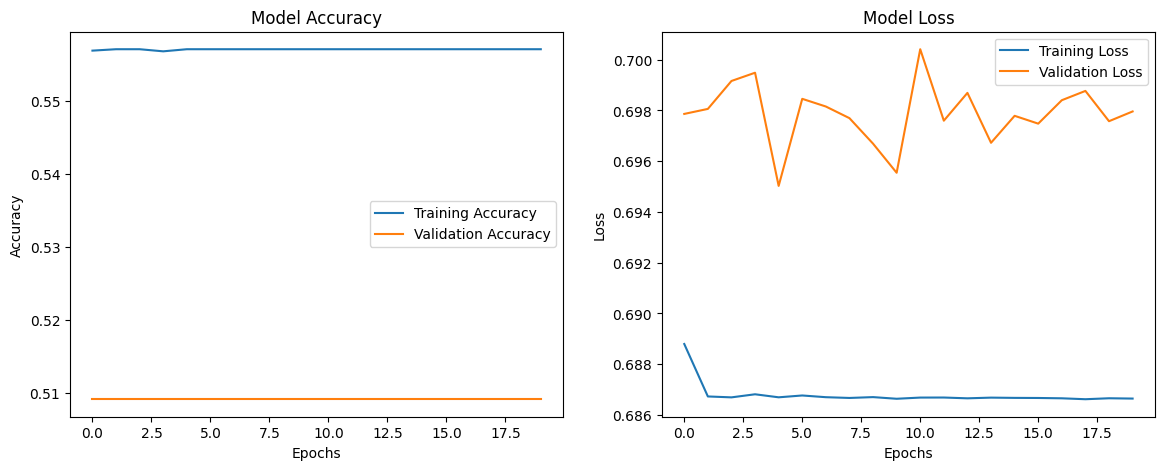

In [33]:
plot_training_history(history_lstm)

In [34]:
# Make predictions
y_pred_probs = lstm_model.predict(X_test)  # Get predicted probabilities
y_pred = (y_pred_probs > 0.5).astype(int)   # Convert to binary predictions

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# Print results
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print("\nConfusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

157/157 ━━━━━━━━━━━━━━━━━━━━ 33s 106ms/step
Accuracy: 0.5626
Precision: 0.5626
Recall: 1.0000
F1 Score: 0.7201

Confusion Matrix:
[[   0 2187]
 [   0 2813]]

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2187
           1       0.56      1.00      0.72      2813

    accuracy                           0.56      5000
   macro avg       0.28      0.50      0.36      5000
weighted avg       0.32      0.56      0.41      5000



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
